In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.dates import DateFormatter
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

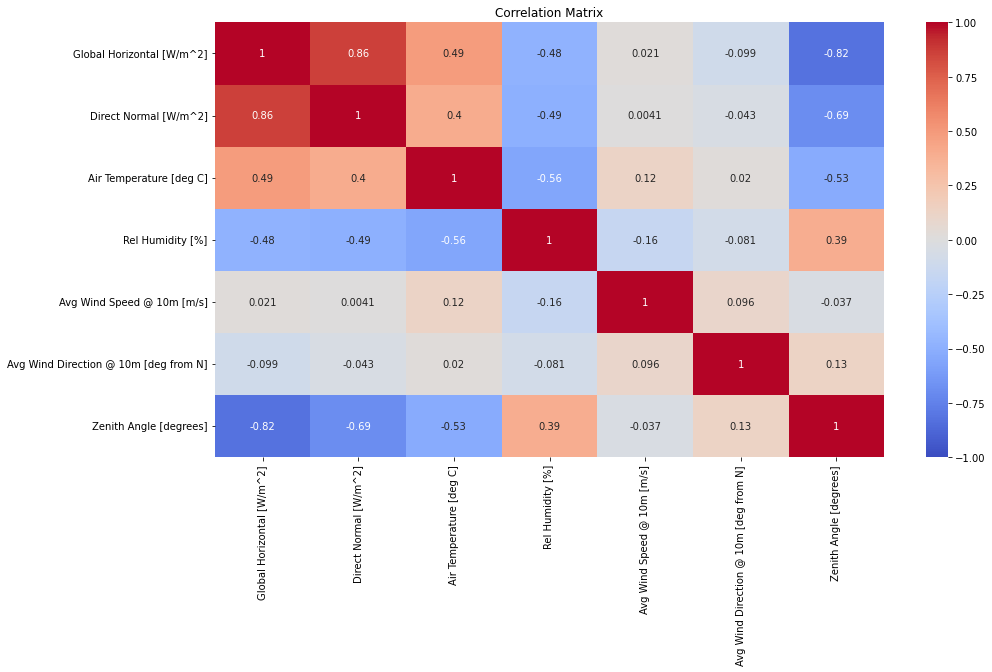

In [41]:
import seaborn as sns
df=pd.read_csv('DNI_hr.csv')
# Calculating the correlation matrix
df_Corr= df.drop(columns=['Date'])
correlation_matrix = df_Corr.corr()



# Plotting the heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

In [42]:
df = df[["Date","Direct Normal [W/m^2]","Zenith Angle [degrees]"]]
df["Date"] = pd.to_datetime(df["Date"])
df.set_index('Date', inplace=True)
df

,Direct Normal [W/m^2],Zenith Angle [degrees]
Date,,
2008-06-01 00:00:00,0.000000,117.671210
2008-06-01 01:00:00,0.000000,114.435478
2008-06-01 02:00:00,0.000000,108.563788
2008-06-01 03:00:00,0.000000,100.647241
2008-06-01 04:00:00,12.084972,91.116848
...,...,...
2013-12-31 19:00:00,0.000000,120.839700
2013-12-31 20:00:00,0.000000,132.365150
2013-12-31 21:00:00,0.000000,143.712933


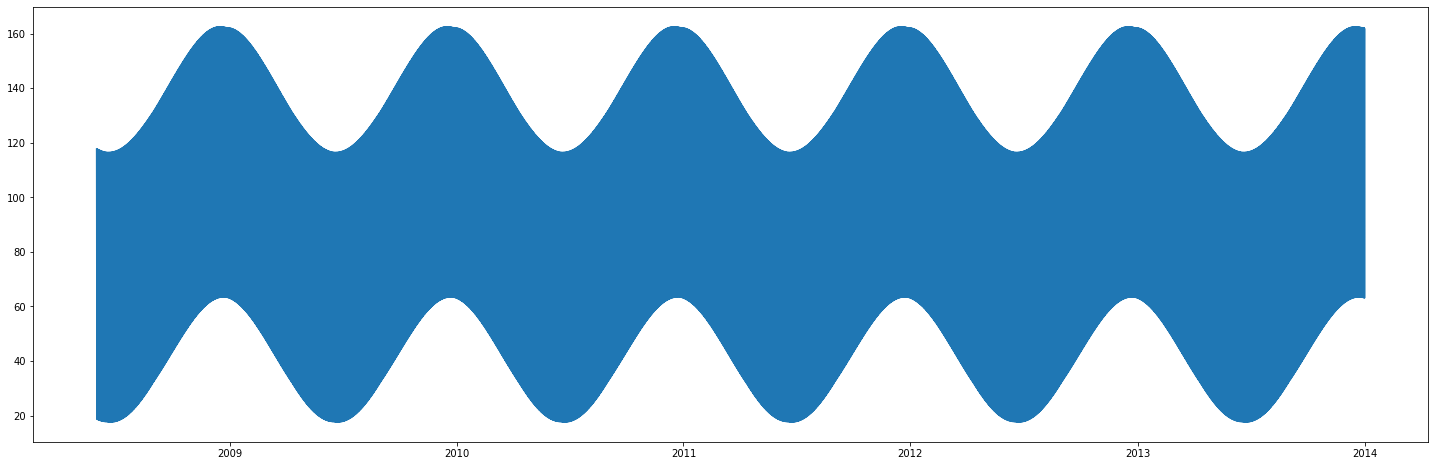

In [43]:
plt.figure(figsize=(25,8))
plt.plot(df['Zenith Angle [degrees]'])

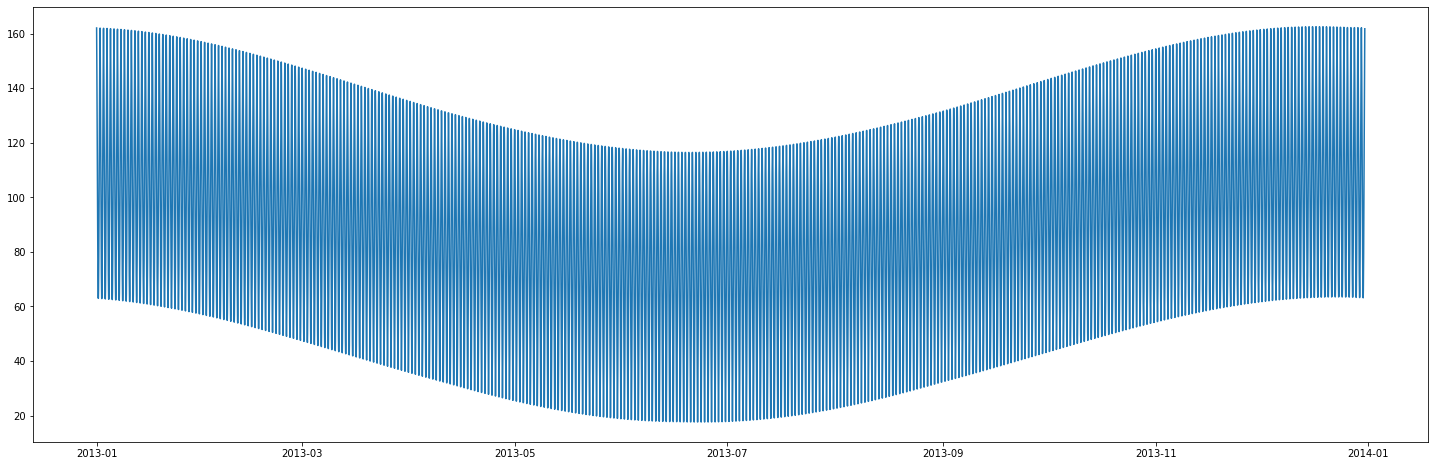

In [44]:
start_date = datetime(2013,1,1)
end_date = datetime(2013,12,30, 23, 0)
lim_df = df[start_date:end_date]

plt.figure(figsize=(25,8))
plt.plot(lim_df['Zenith Angle [degrees]'])

In [45]:
from datetime import timedelta
train_end = datetime(2013,12,30, 23, 0)
test_end = datetime(2013,12,31,23,0)
train_DNI = df['Direct Normal [W/m^2]'][:train_end]
test_DNI = df['Direct Normal [W/m^2]'][train_end + timedelta(hours=1):test_end]

print(test_DNI)

Date
2013-12-31 00:00:00      0.000000
2013-12-31 01:00:00      0.000000
2013-12-31 02:00:00      0.000000
2013-12-31 03:00:00      0.000000
2013-12-31 04:00:00      0.000000
2013-12-31 05:00:00      0.000000
2013-12-31 06:00:00      0.000000
2013-12-31 07:00:00     40.792716
2013-12-31 08:00:00    113.515562
2013-12-31 09:00:00    756.796170
2013-12-31 10:00:00    928.282217
2013-12-31 11:00:00    950.121717
2013-12-31 12:00:00    935.673867
2013-12-31 13:00:00    871.078967
2013-12-31 14:00:00    797.725500
2013-12-31 15:00:00    129.039664
2013-12-31 16:00:00     93.549584
2013-12-31 17:00:00      0.000000
2013-12-31 18:00:00      0.000000
2013-12-31 19:00:00      0.000000
2013-12-31 20:00:00      0.000000
2013-12-31 21:00:00      0.000000
2013-12-31 22:00:00      0.000000
2013-12-31 23:00:00      0.000000
Name: Direct Normal [W/m^2], dtype: float64


In [46]:
train_Zenith = df['Zenith Angle [degrees]'][:train_end]

In [47]:
naive_Zenith = train_Zenith.loc['2012-12-31'].reset_index(drop=True)
test_Zenith = pd.Series(naive_Zenith.values, index=test_DNI.index)

In [48]:
from typing import Union
def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [53]:
ps = range(0, 3, 1)
qs = range(0, 3, 1)
Ps = range(0, 3, 1)
Qs = range(0, 3, 1)

SARIMAX_order_list = list(product(ps, qs, Ps, Qs))


d = 0
D = 0
s = 24

SARIMAX_result_df = optimize_SARIMAX(train_DNI, train_Zenith, SARIMAX_order_list, d, D, s)
SARIMAX_result_df

  0%|          | 0/81 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(2, 0, 2, 2)",16.000000
1,"(2, 2, 2, 2)",620366.906114
2,"(1, 1, 1, 1)",620450.023221
3,"(2, 1, 1, 2)",620467.862208
4,"(2, 1, 2, 1)",620506.831580
...,...,...
71,"(0, 0, 2, 0)",685020.453970
72,"(0, 0, 1, 0)",690488.986895
73,"(0, 0, 0, 2)",700994.833771
74,"(0, 0, 0, 1)",708736.970176


In [57]:
SARIMAX_model = SARIMAX(train_DNI, exog = train_Zenith, order=(2,0,2), seasonal_order=(2,0,2,24), simple_differencing=False)
SARIMAX_model_fit = SARIMAX_model.fit(disp=False)

print(SARIMAX_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:              Direct Normal [W/m^2]   No. Observations:                48936
Model:             SARIMAX(2, 0, 2)x(2, 0, 2, 24)   Log Likelihood             -310173.453
Date:                            Fri, 02 Aug 2024   AIC                         620366.906
Time:                                    21:12:36   BIC                         620454.889
Sample:                                06-01-2008   HQIC                        620394.494
                                     - 12-30-2013                                         
Covariance Type:                              opg                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Zenith Angle [degrees]    -0.0643      0.030     -2.138      0.033      -0.123      -0.005

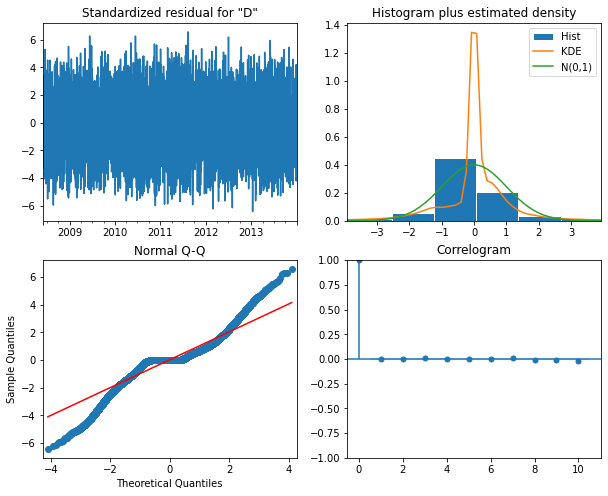

In [58]:
SARIMAX_model_fit.plot_diagnostics(figsize=(10, 8));

In [59]:
SARIMAX_pred = SARIMAX_model_fit.forecast(len(test_DNI),exog = test_Zenith)
predictions = pd.Series(SARIMAX_pred, index=test_DNI.index)
residuals = test_DNI - predictions
print("Root Mean Squared Error:", np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 154.13195800340688


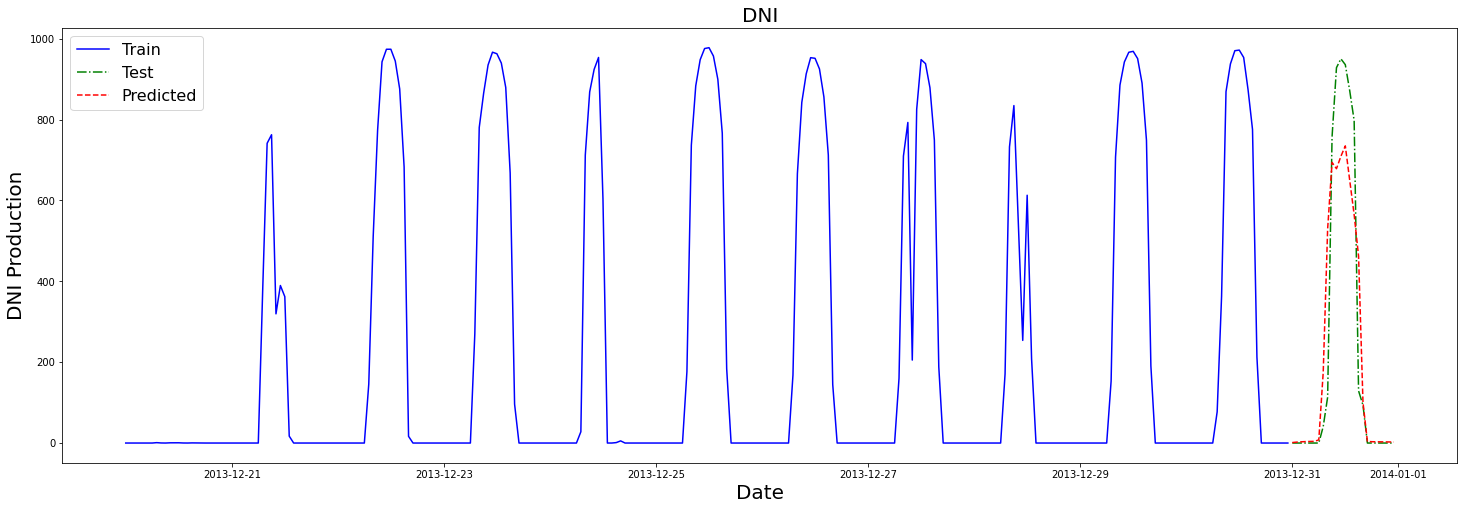

In [60]:
#plot prediction
start_date = datetime(2013,12,20)
end_date = datetime(2013,12,30, 23, 0)
lim_train_DNI = train_DNI[start_date:end_date]

plt.figure(figsize=(25,8))

plt.plot(lim_train_DNI,'b-', label='Train')
plt.plot(test_DNI,'g-.', label='Test')
plt.plot(predictions, 'r--', label='Predicted')
plt.legend(loc=2,fontsize=16)

plt.title('DNI', fontsize=20)
plt.xlabel('Date',fontsize=20)
plt.ylabel('DNI Production', fontsize=20)
plt.show()

# long term forecast

In [61]:
from datetime import timedelta
train_end = datetime(2013,12,24, 23, 0)
test_end = datetime(2013,12,31,23,0)
train_DNI = df['Direct Normal [W/m^2]'][:train_end]
test_DNI = df['Direct Normal [W/m^2]'][train_end + timedelta(hours=1):test_end]

In [62]:
train_Zenith = df['Zenith Angle [degrees]'][:train_end]

In [64]:
naive_Zenith = train_Zenith[-len(test_DNI):].reset_index(drop=True)
test_Zenith = pd.Series(naive_Zenith.values, index=test_DNI.index)

In [66]:
SARIMAX_model = SARIMAX(train_DNI, exog = train_Zenith, order=(2,0,2), seasonal_order=(2,0,2,24), simple_differencing=False)
SARIMAX_model_fit = SARIMAX_model.fit(disp=False)

print(SARIMAX_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:              Direct Normal [W/m^2]   No. Observations:                48792
Model:             SARIMAX(2, 0, 2)x(2, 0, 2, 24)   Log Likelihood             -309283.758
Date:                            Sat, 03 Aug 2024   AIC                         618587.516
Time:                                    00:16:49   BIC                         618675.469
Sample:                                06-01-2008   HQIC                        618615.098
                                     - 12-24-2013                                         
Covariance Type:                              opg                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Zenith Angle [degrees]    -0.0542      0.510     -0.106      0.915      -1.055       0.946

In [67]:
SARIMAX_pred = SARIMAX_model_fit.forecast(len(test_DNI),exog = test_Zenith)
predictions = pd.Series(SARIMAX_pred, index=test_DNI.index)
residuals = test_DNI - predictions
print("Root Mean Squared Error:", np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 181.81933934695093


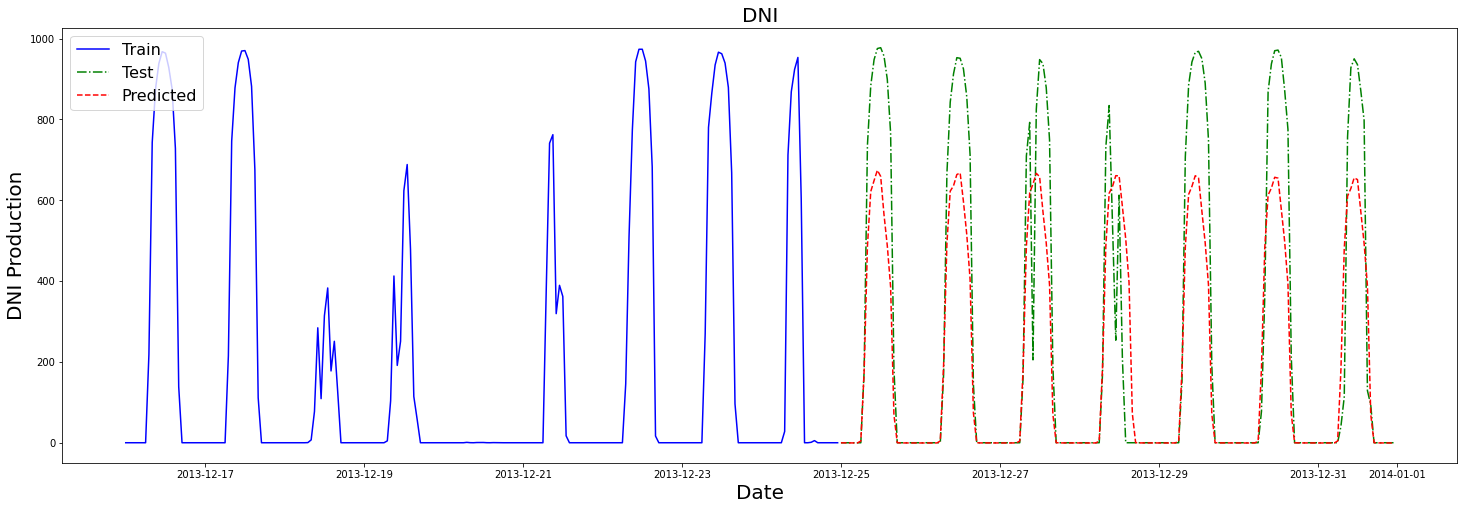

In [68]:
#plot prediction
start_date = datetime(2013,12,16)
end_date = datetime(2013,12,24, 23, 0)
lim_train_DNI = train_DNI[start_date:end_date]

plt.figure(figsize=(25,8))

plt.plot(lim_train_DNI,'b-', label='Train')
plt.plot(test_DNI,'g-.', label='Test')
plt.plot(predictions, 'r--', label='Predicted')
plt.legend(loc=2,fontsize=16)

plt.title('DNI', fontsize=20)
plt.xlabel('Date',fontsize=20)
plt.ylabel('DNI Production', fontsize=20)
plt.show()